In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 1. Define file paths for the multimodal predictions
files = [
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_benign_with_logo.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_benign_without_logo.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_Fresh_Logo_Phishing.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_Learned_Logo_Phishing.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_No_Logo_Phishing.csv"
]

# 2. Load all multimodal prediction CSV files into one DataFrame
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
df_multi = pd.concat(dfs, ignore_index=True)

# 3. Load ground truth file (assumes test.csv contains 'url' and 'label', where label: 0=benign, 1=phishing)
ground_truth_file = "/home/tiffanybao/PhishIntention/datasets/test.csv"
df_truth = pd.read_csv(ground_truth_file)

# 4. Merge predictions with ground truth on the 'url' column
df_merged = pd.merge(df_multi, df_truth[['url', 'label']], on='url', how='inner')

# 5. Extract the LLM Image branch predictions from the "Image_Decision" column.
#    Ensure the values are integer (0 for benign, 1 for phishing).
df_merged["Image_Decision"] = df_merged["Image_Decision"].astype(int)

# 6. Compute performance metrics using the ground truth vs. LLM Image predictions.
y_true = df_merged["label"]
y_pred = df_merged["Image_Decision"]

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# 7. Print the results
print("LLM Image Branch Model Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print("Error Counts:")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")


LLM Image Branch Model Performance:
Accuracy : 0.6679
Precision: 0.9437
Recall   : 0.5132
Error Counts:
  False Positives (FP): 22
  False Negatives (FN): 350


In [4]:
# Cell 5: Define helper functions for the original model predictions
def merge_with_ground_truth(predictions_df, ground_truth_file):
    """
    Merges the predictions DataFrame with the ground truth labels from test.csv.
    The merge is done on the 'url' column. Assumes test.csv has a 'url' column and a 'label' column.
    """
    truth_df = pd.read_csv(ground_truth_file)
    merged_df = pd.merge(predictions_df, truth_df[['url', 'label']], on='url', how='inner')
    return merged_df

def compute_metrics(merged_df):
    """
    Computes evaluation metrics:
      - Confusion matrix (extracting FP and FN)
      - Accuracy, precision, recall
      - ROC AUC using a continuous score (fused_score)
    Returns a dictionary with the metrics.
    """
    y_true = merged_df['label']
    y_pred = merged_df['pred_label']
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    
  

    metrics = {
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
    }
    return metrics



def load_original_prediction_files(file_paths):
    """
    Loads multiple original model prediction CSV files (which have no header)
    and concatenates them into one DataFrame.
    Assumes columns in order: 
      Site Folder, url, pred_decision, col4, col5, score.
    """
    dfs = []
    for file in file_paths:
        df = pd.read_csv(file, header=None, names=["Site Folder", "url", "pred_decision", "col4", "col5", "score"])
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

def convert_predictions_ori(df):
    """
    For the original model, the predictions are already numeric:
    - 'pred_decision' is 0 (benign) or 1 (phishing).
    - 'score' is a continuous value.
    Sets these as 'pred_label' and 'fused_score' respectively.
    """
    df['pred_label'] = df['pred_decision'].astype(int)
    df['fused_score'] = df['score'].astype(float)
    return df


# Cell 6: File paths for the original model prediction CSV files
ori_prediction_files = [
    "/home/tiffanybao/PhishIntention/results/4.12/ori_common_benign_with_logo.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/ori_common_benign_without_logo.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/ori_common_Fresh_Logo_Phishing.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/ori_common_Learned_Logo_Phishing.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/ori_common_No_Logo_Phishing.csv"
]

def load_original_prediction_files(file_paths):
    """
    Loads multiple original model prediction CSV files which have headers.
    The expected columns are: folder, url, phish_category, pred_target, matched_domain, siamese_conf.
    """
    dfs = []
    for file in file_paths:
        df = pd.read_csv(file)  # CSVs have headers
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

def convert_predictions_ori(df):
    """
    For the original model:
      - 'phish_category' is the binary decision (1: phishing, 0: benign).
      - 'siamese_conf' is the continuous confidence score.
    We assign these to 'pred_label' and 'fused_score' respectively.
    """
    df['pred_label'] = df['phish_category'].astype(int)
    df['fused_score'] = df['siamese_conf'].astype(float)
    return df

# Load original model predictions
ori_df = load_original_prediction_files(ori_prediction_files)

# Convert the predictions (assign binary labels and continuous score)
ori_df = convert_predictions_ori(ori_df)

# Merge with ground truth
ori_merged = merge_with_ground_truth(ori_df, ground_truth_file)

# Compute performance metrics
ori_metrics = compute_metrics(ori_merged)
print("Image Analysis Model Evaluation Metrics:")
for metric, value in ori_metrics.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")


Image Analysis Model Evaluation Metrics:
TP: 147
TN: 401
FP: 0
FN: 572
accuracy: 0.4893
precision: 1.0000
recall: 0.2045


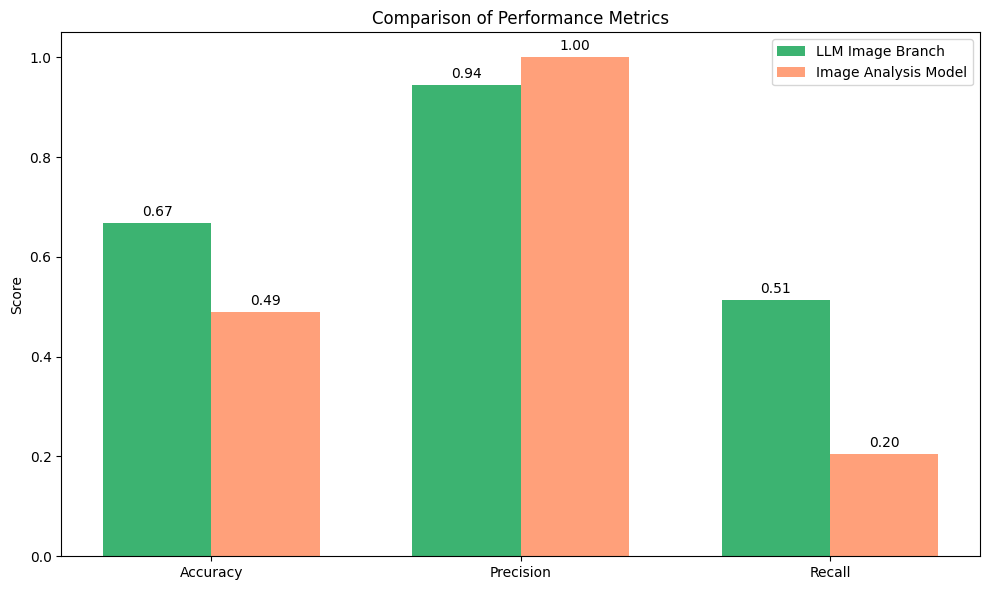

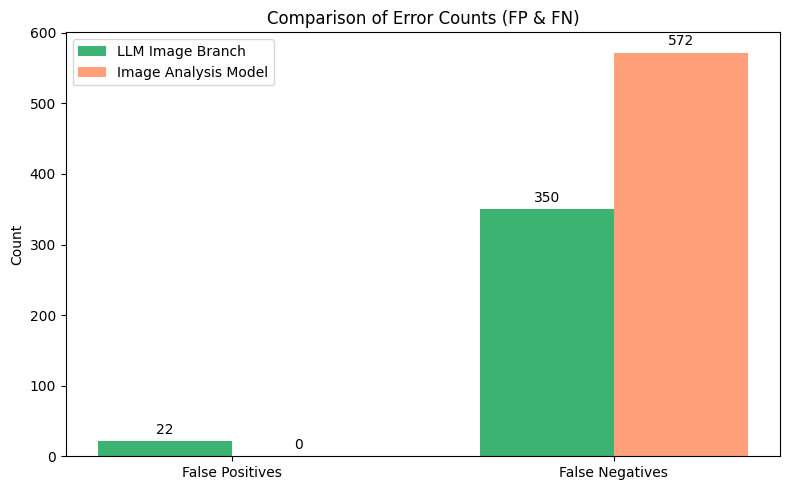

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# --- Performance Metrics Comparison (Accuracy, Precision, Recall) ---

llm_metrics = {
    'accuracy': accuracy,         # computed in your LLM Image branch cell
    'precision': precision,       # computed in your LLM Image branch cell
    'recall': recall,             # computed in your LLM Image branch cell
    'FP': fp,                     # from confusion_matrix
    'FN': fn                      # from confusion_matrix
}

# Define labels for the performance metrics
performance_labels = ['Accuracy', 'Precision', 'Recall']

# Prepare the data for each model
llm_values = [llm_metrics['accuracy'], llm_metrics['precision'], llm_metrics['recall']]
ori_values = [ori_metrics['accuracy'], ori_metrics['precision'], ori_metrics['recall']]

# Set the positions for the groups on the x-axis
x = np.arange(len(performance_labels))
bar_width = 0.35  # Adjust bar width for two models

fig, ax = plt.subplots(figsize=(10, 6))
bars_llm = ax.bar(x - bar_width/2, llm_values, bar_width, label='LLM Image Branch', color='mediumseagreen')
bars_ori = ax.bar(x + bar_width/2, ori_values, bar_width, label='Image Analysis Model', color='lightsalmon')

ax.set_xticks(x)
ax.set_xticklabels(performance_labels)
ax.set_ylabel('Score')
ax.set_title('Comparison of Performance Metrics')
ax.legend()

# Annotate bars with their values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # vertical offset in points
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(bars_llm)
autolabel(bars_ori)

plt.tight_layout()
plt.show()

# --- Error Counts Comparison (FP & FN) ---

# Define error labels and data
error_labels = ['False Positives', 'False Negatives']
llm_errors = [llm_metrics['FP'], llm_metrics['FN']]
ori_errors = [ori_metrics['FP'], ori_metrics['FN']]

x_err = np.arange(len(error_labels))
bar_width_err = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars_llm_err = ax.bar(x_err - bar_width_err/2, llm_errors, bar_width_err, label='LLM Image Branch', color='mediumseagreen')
bars_ori_err = ax.bar(x_err + bar_width_err/2, ori_errors, bar_width_err, label='Image Analysis Model', color='lightsalmon')

ax.set_xticks(x_err)
ax.set_xticklabels(error_labels)
ax.set_ylabel('Count')
ax.set_title('Comparison of Error Counts (FP & FN)')
ax.legend()

def autolabel_err(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel_err(bars_llm_err)
autolabel_err(bars_ori_err)

plt.tight_layout()
plt.show()


LLM Text Vs Bare Text

In [7]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# 1. Define file paths for the multimodal predictions
files = [
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_benign_with_logo.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_benign_without_logo.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_Fresh_Logo_Phishing.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_Learned_Logo_Phishing.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/multi_common_No_Logo_Phishing.csv"
]

# 2. Load all multimodal prediction CSV files into one DataFrame
dfs = []
for file in files:
    df = pd.read_csv(file)
    dfs.append(df)
df_multi = pd.concat(dfs, ignore_index=True)

# 3. Load ground truth file (assumes test.csv contains 'url' and 'label', where label: 0=benign, 1=phishing)
ground_truth_file = "/home/tiffanybao/PhishIntention/datasets/test.csv"
df_truth = pd.read_csv(ground_truth_file)

# 4. Merge predictions with ground truth on the 'url' column
df_merged = pd.merge(df_multi, df_truth[['url', 'label']], on='url', how='inner')

# 5. Extract the LLM Image branch predictions from the "Image_Decision" column.
#    Ensure the values are integer (0 for benign, 1 for phishing).
df_merged["Text_Decision"] = df_merged["Text_Decision"].astype(int)

# 6. Compute performance metrics using the ground truth vs. LLM Image predictions.
y_true = df_merged["label"]
y_pred = df_merged["Text_Decision"]

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# 7. Print the results
print("LLM Text Branch Model Performance:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print("Error Counts:")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")


LLM Text Branch Model Performance:
Accuracy : 0.6384
Precision: 0.9816
Recall   : 0.4451
Error Counts:
  False Positives (FP): 6
  False Negatives (FN): 399


In [8]:
import os
import pandas as pd

def load_text_prediction_files(file_paths):
    """
    Loads multiple text model prediction CSV files (which have headers)
    and concatenates them into one DataFrame.
    Expected CSV files are assumed to have at least the following columns:
      - 'phish_category' : the binary decision (0 for benign, 1 for phishing)
      - 'phish_score' : a continuous confidence score (if available)
    The function also adds a 'true_label' column based on the filename:
      If the filename contains 'benign', then true_label is 0; otherwise, 1.
    """
    dfs = []
    for file in file_paths:
        df = pd.read_csv(file)
        # Set true label based on file name
        if 'benign' in file.lower():
            df['true_label'] = 0
        else:
            df['true_label'] = 1
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

def convert_predictions_text(df):
    """
    For the text analysis model:
      - 'phish_category' holds the binary prediction (0: benign, 1: phishing),
      - 'phish_score' holds a continuous score.
    We set these as 'pred_label' (integer) and 'fused_score' (float) respectively.
    """
    df['pred_label'] = df['phish_category'].astype(int)
    df['fused_score'] = df['phish_score'].astype(float)
    return df


# Cell B: File paths for the text analysis model prediction CSV files
text_prediction_files = [
    "/home/tiffanybao/PhishIntention/results/4.12/rule_based/benign_with_logo_predict.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/rule_based/benign_without_logo_predict.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/rule_based/Fresh_Logo_Phishing_predict.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/rule_based/Learned_Logo_Phishing_predict.csv",
    "/home/tiffanybao/PhishIntention/results/4.12/rule_based/No_Logo_Phishing_predict.csv"
]

# Load the text model predictions
text_df = load_text_prediction_files(text_prediction_files)

# Convert predictions to standard format
text_df = convert_predictions_text(text_df)

# Merge with the ground truth (assumes ground_truth_file is defined, e.g., "/home/tiffanybao/PhishIntention/datasets/test.csv")
text_merged = merge_with_ground_truth(text_df, ground_truth_file)

# Compute performance metrics for the text model
text_metrics = compute_metrics(text_merged)
print("Text Analysis Model Evaluation Metrics:")
for metric, value in text_metrics.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")


Text Analysis Model Evaluation Metrics:
TP: 523
TN: 78
FP: 332
FN: 217
accuracy: 0.5226
precision: 0.6117
recall: 0.7068


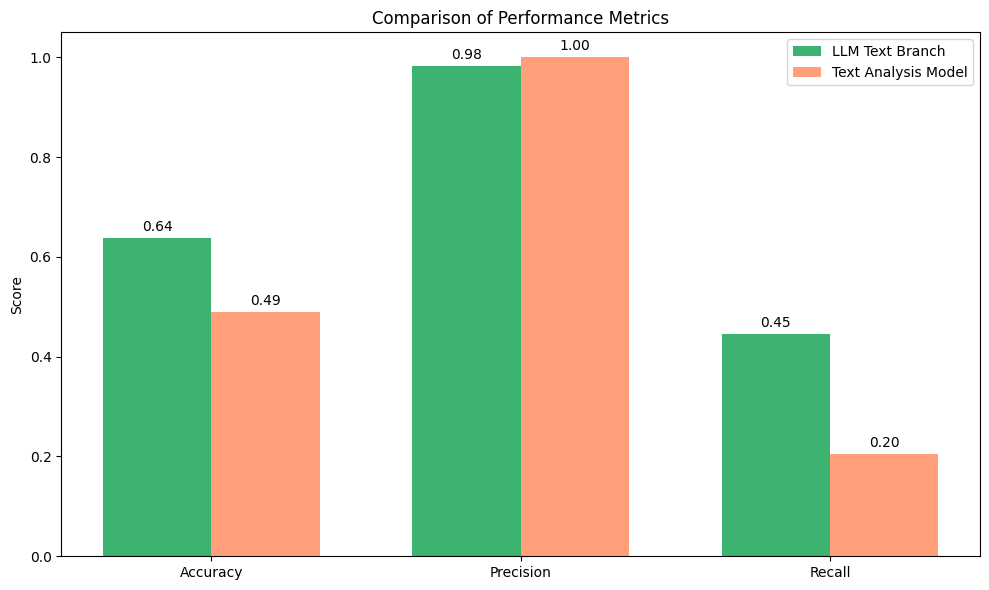

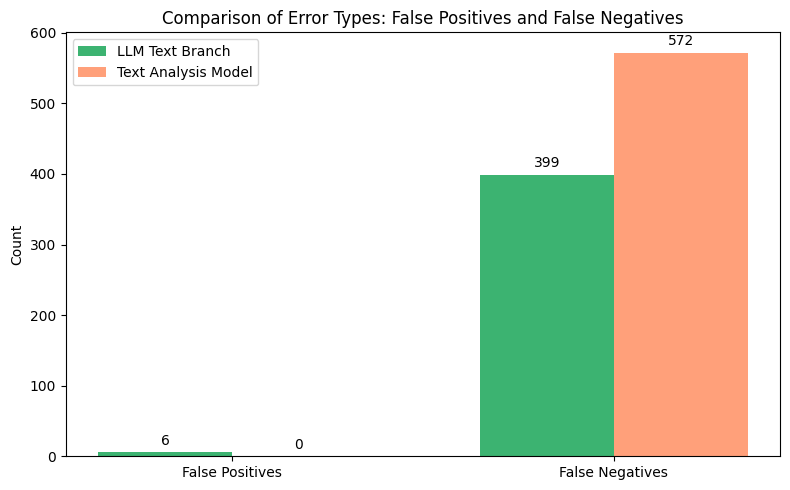

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# --- Performance Metrics Comparison (Accuracy, Precision, Recall) ---

llm_metrics = {
    'accuracy': accuracy,         # computed in your LLM Image branch cell
    'precision': precision,       # computed in your LLM Image branch cell
    'recall': recall,             # computed in your LLM Image branch cell
    'FP': fp,                     # from confusion_matrix
    'FN': fn                      # from confusion_matrix
}

# Define labels for the performance metrics
performance_labels = ['Accuracy', 'Precision', 'Recall']

# Prepare the data for each model
llm_values = [llm_metrics['accuracy'], llm_metrics['precision'], llm_metrics['recall']]
ori_values = [ori_metrics['accuracy'], ori_metrics['precision'], ori_metrics['recall']]

# Set the positions for the groups on the x-axis
x = np.arange(len(performance_labels))
bar_width = 0.35  # Adjust bar width for two models

fig, ax = plt.subplots(figsize=(10, 6))
bars_llm = ax.bar(x - bar_width/2, llm_values, bar_width, label='LLM Text Branch', color='mediumseagreen')
bars_ori = ax.bar(x + bar_width/2, ori_values, bar_width, label='Text Analysis Model', color='lightsalmon')

ax.set_xticks(x)
ax.set_xticklabels(performance_labels)
ax.set_ylabel('Score')
ax.set_title('Comparison of Performance Metrics')
ax.legend()

# Annotate bars with their values
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # vertical offset in points
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(bars_llm)
autolabel(bars_ori)

plt.tight_layout()
plt.show()

# --- Error Counts Comparison (FP & FN) ---

# Define error labels and data
error_labels = ['False Positives', 'False Negatives']
llm_errors = [llm_metrics['FP'], llm_metrics['FN']]
ori_errors = [ori_metrics['FP'], ori_metrics['FN']]

x_err = np.arange(len(error_labels))
bar_width_err = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars_llm_err = ax.bar(x_err - bar_width_err/2, llm_errors, bar_width_err, label='LLM Text Branch', color='mediumseagreen')
bars_ori_err = ax.bar(x_err + bar_width_err/2, ori_errors, bar_width_err, label='Text Analysis Model', color='lightsalmon')

ax.set_xticks(x_err)
ax.set_xticklabels(error_labels)
ax.set_ylabel('Count')
ax.set_title('Comparison of Error Types: False Positives and False Negatives')
ax.legend()

def autolabel_err(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel_err(bars_llm_err)
autolabel_err(bars_ori_err)

plt.tight_layout()
plt.show()
